### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix#,plot_confusion_matrix
from sklearn import metrics
import itertools

%matplotlib inline

### Functions

In [2]:
def classes_counter(dataset):
    K = len(set(dataset.targets.numpy()))
    return K

def dataloader_batch(train_dataset,test_dataset,batch_size=128):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
    # to prevent unwanted correlation in train_data we shuffle train data
    test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)
    return train_loader,test_loader


def create_model_and_train(K,train_dataset,test_dataset,batch_size=128,n_epochs=100):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = RNN(28,128,2,10,device)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    train_loader,test_loader = dataloader_batch(train_dataset,test_dataset,batch_size=batch_size)
    
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)
    
    for it in range(n_epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs,targets = inputs.to(device), targets.to(device)
            inputs = inputs.view(-1,28,28)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        
        test_loss = []
        for inputs, targets in test_loader:
            inputs,targets = inputs.to(device), targets.to(device)
            inputs = inputs.view(-1,28,28)
            
            outputs = model(inputs)

            loss = criterion(outputs, targets)
                        
            test_loss.append(loss.item())
            
        test_loss = np.mean(test_loss)
        
        train_losses[it] = train_loss
        test_losses[it]  = test_loss
        
        dt = datetime.now() - t0
        print(f"Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")
        
    return model,train_losses, test_losses, device, train_loader, test_loader


def plot_test_and_train_metric(train, test, metric):
    plt.plot(train, label=f"train {metric}")
    plt.plot(test, label =f"test {metric}")
    plt.legend()
    plt.show
    

def acc_compouter(model,device,data_loader):
    n_correct=0.
    n_total=0.
    
    for inputs,targets in data_loader:
        inputs,targets = inputs.to(device), targets.to(device)
        inputs = inputs.view(-1,28,28)

        outputs = model(inputs)
        
        _,predictions = torch.max(outputs,1)
        # 1 is the axis and  _ is the max value that is not needed here
        
        n_correct += (predictions == targets).sum().item()
        # .item() from torch to simple python data type
        n_total += targets.shape[0]
        
    train_acc = n_correct/n_total

    return train_acc

def predict_model(model,data_loader,dataset,device):
    x = dataset.data.numpy()
    y = dataset.targets.numpy()
    p = np.array([])
    for inputs,targets in data_loader:
        inputs = inputs.to(device)
        inputs = inputs.view(-1,28,28)
        
        outputs = model(inputs)
        _,predictions = torch.max(outputs,1)
        p = np.concatenate((p,predictions.cpu().numpy()))
        
    return p,y,x

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)
    
    plt.imshow(cm, interpolation="nearest",cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = ".2f" if normalize else "d"
    thresh = cm.max()/2.
    
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

### Load data

In [3]:
# train_dataset_Fashion = torchvision.datasets.FashionMNIST(root=".",train=True,transform = transforms.ToTensor(),download=True)
# test_dataset_Fashion = torchvision.datasets.FashionMNIST(root=".",train=False ,transform = transforms.ToTensor(),download=True)

test_dataset_MNIST = torchvision.datasets.MNIST(root=".",train=False,transform=transforms.ToTensor(),download=True)
train_dataset_MNIST = torchvision.datasets.MNIST(root=".",train=True,transform=transforms.ToTensor(),download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
test_dataset_MNIST.data.max()

tensor(255, dtype=torch.uint8)

In [5]:
test_dataset_MNIST.data.shape

torch.Size([10000, 28, 28])

In [6]:
test_dataset_MNIST.targets

tensor([7, 2, 1,  ..., 4, 5, 6])

In [9]:
# K_Fashion = classes_counter(train_dataset_Fashion)
# print(K_Fashion)

K_MNIST   = classes_counter(train_dataset_MNIST)
print(K_MNIST)

10


### Create model

In [10]:
class RNN(nn.Module):
    def __init__(self,n_inputs, n_hidden, n_rnnlayers, n_outputs, device):
        super(RNN,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.device = device
        
        self.rnn = nn.LSTM(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            batch_first=True
        )
            
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(self.device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(self.device)
        out,_ = self.rnn(X, (h0,c0))

        
        out = self.fc(out[:, -1, :])
        return out

#### MNIST RNN

In [11]:
model_MNIST, train_losses_MNIST, test_losses_MNIST, device ,train_loader_MNIST, test_loader_MNIST = create_model_and_train(K_MNIST,train_dataset_MNIST,test_dataset_MNIST,batch_size=128,n_epochs=10)

cuda:0
Epoch 1/10, Train Loss: 0.5599, Test Loss: 0.2047, Duration: 0:00:15.489151
Epoch 2/10, Train Loss: 0.1382, Test Loss: 0.1101, Duration: 0:00:20.676246
Epoch 3/10, Train Loss: 0.0915, Test Loss: 0.0760, Duration: 0:00:15.346063
Epoch 4/10, Train Loss: 0.0657, Test Loss: 0.0629, Duration: 0:00:15.301012
Epoch 5/10, Train Loss: 0.0523, Test Loss: 0.0571, Duration: 0:00:15.250960
Epoch 6/10, Train Loss: 0.0441, Test Loss: 0.0534, Duration: 0:00:15.292653
Epoch 7/10, Train Loss: 0.0381, Test Loss: 0.0451, Duration: 0:00:15.404223
Epoch 8/10, Train Loss: 0.0326, Test Loss: 0.0454, Duration: 0:00:15.547793
Epoch 9/10, Train Loss: 0.0284, Test Loss: 0.0425, Duration: 0:00:15.465516
Epoch 10/10, Train Loss: 0.0267, Test Loss: 0.0443, Duration: 0:00:15.428862


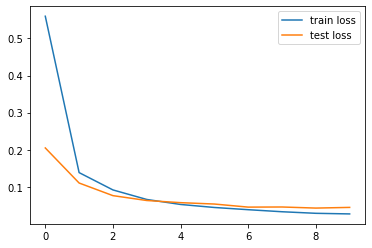

In [12]:
plot_test_and_train_metric(train_losses_MNIST, test_losses_MNIST,"loss")

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader_MNIST,test_loader_MNIST = dataloader_batch(train_dataset_MNIST,test_dataset_MNIST,batch_size=128)

In [18]:
train_acc_MNIST = acc_compouter(model_MNIST,device,train_loader_MNIST)
print(f"train acc: {train_acc_MNIST}")

test_acc_MNIST = acc_compouter(model_MNIST,device,test_loader_MNIST)
print(f"test acc: {test_acc_MNIST}")

train acc: 0.99145
test acc: 0.9864


Confusion matrix, without normalization
[[ 961    0    2    0    0   11    4    1    1    0]
 [   0 1117    4    1    0    1    2    2    8    0]
 [   0    0 1028    0    0    0    1    2    1    0]
 [   0    0    3 1001    0    4    0    0    2    0]
 [   0    0    0    0  960    0    5    0    0   17]
 [   0    0    0    5    0  885    1    0    1    0]
 [   0    1    2    0    1    8  943    0    3    0]
 [   1    1    7    3    1    0    0 1011    0    4]
 [   1    0    1    2    0    3    1    2  961    3]
 [   0    0    0    0    5    4    0    3    0  997]]


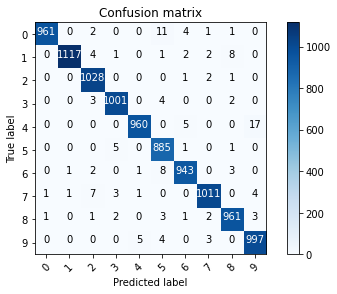

In [19]:
p_test_MNIST,y_test_MNIST,x_test_MNIST = predict_model(model_MNIST,test_loader_MNIST,test_dataset_MNIST,device)

cm_MNIST = confusion_matrix(y_test_MNIST,p_test_MNIST)
plot_confusion_matrix(cm_MNIST, list(range(K_MNIST)))